In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

#import geopandas as gpd
#from shapely import geometry
#from geopandas import GeoSeries, GeoDataFrame

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
#import statsmodels.api as sm

from textwrap import wrap

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler
from sklearn import linear_model


# Import Data

In [3]:
#read data in from pickle file
df = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_for_model_prec62.pkl')

In [4]:
df.shape

(132, 7)

In [5]:
df.head(1)

,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,LAW_CAT_CD,OFNS_DESC,CAT_OFNS,CMPLNT_NUM_count
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19


# Model crime incidence with basic Time Series
P = centroid of precinct 62   
R = 0.5 miles (2640 feet)  
O = Grand Larceny (felony with the highest incidence in all boroughs)  

In [6]:
#rename columns
df.rename(columns={'CMPLNT_FR_DATE_YEAR':'YEAR',
 'CMPLNT_FR_DATE_MONTH':'MONTH',
 'LAW_CAT_CD':'CRIME_CAT',
 'OFNS_DESC':'OFFENSE',
 'CMPLNT_NUM_count':'COUNT'}, inplace = True)

In [7]:
df.head(1)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19


** Set up as a time series **

In [8]:
#create a date (set date for each month as 1st of the month)
df['DAY'] = 1 
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
#order by date
df = df.sort_values('DATE')

In [10]:
df.head()

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01
29,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01
55,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01
79,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01
100,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01


In [11]:
#check that there is an observation for all 132 months(12 months * 11 years)
len(df.DATE.unique()), len(df)

(132, 132)

# Visualize the Time Series

In [12]:
#set up the title for the plots
titleHM = 'Grand Larceny, 1/2 mile of Precinct 62 Centroid'
n_t = len(titleHM)

Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\nTime Series')

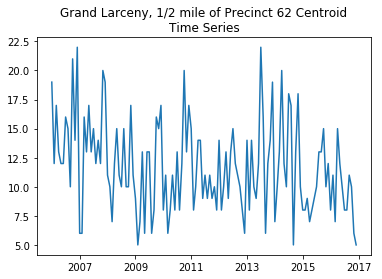

In [13]:
#plot the time series
plt.plot(df.DATE, df.COUNT)
plt.title("\n".join(wrap(titleHM + ' Time Series',n_t)))

Plot shows potential cyclic and seasonal components

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

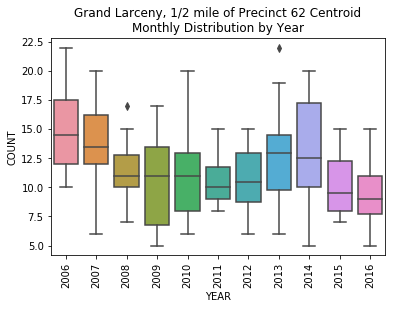

In [14]:
#View distribution of months by year
sns.boxplot(x ='YEAR', y='COUNT' , data = df)
plt.title("\n".join(wrap(titleHM + ' Monthly Distribution by Year',n_t)))
plt.xticks(rotation=90)

Precinct 62 does not have a clear trend or cycle. 
  
Precinct 75 showed a slightly increasing overall trend, as well as a possible 5 year cycle (increases and then drops between 2006 and 2010 and again between 2011 and 2015).  The distribution by month varies by year (disribution is tighter for 2007 but much wider for 2009)and there are notable outliers in most years.  

Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\ntrend by month by year')

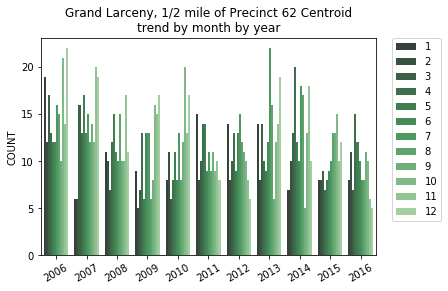

In [15]:
#view trend by month by year
sns.barplot(x="YEAR", y="COUNT",hue="MONTH",
              data=df, palette='Greens_d',estimator=lambda x:sum(x)/len(x))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('')
plt.xticks(rotation=30) 
plt.title("\n".join(wrap(titleHM + ' trend by month by year',n_t)))

In [16]:
#get the count for each year
YEAR_COUNT = df[['YEAR','COUNT']].groupby('YEAR',as_index=False).sum()

In [17]:
#rename the count column
YEAR_COUNT.rename(columns = {'COUNT':'YEAR_COUNT'},inplace=True)

In [18]:
#merge with the dataframe
df = df.merge(YEAR_COUNT, on='YEAR', how = 'left')

In [19]:
df['PCT_YEAR_COUNT'] = df.COUNT / df.YEAR_COUNT

In [20]:
df.head(1)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,PCT_YEAR_COUNT
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,0.103825


Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\nPct of Year by Month')

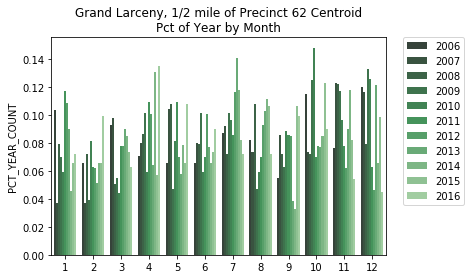

In [21]:
#view percent of year, by month by year
sns.barplot(x="MONTH", y="PCT_YEAR_COUNT",hue="YEAR",
              data=df, palette='Greens_d')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('')
plt.title("\n".join(wrap(titleHM + ' Pct of Year by Month',n_t)))

In [22]:
#set up quarters field
quarters = {1:1,2:1,3:1,4:2,5:2,6:2,7:3,8:3,9:3,10:4,11:4,12:4}
df['Q'] = df.MONTH.map(quarters)

Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\nTime Series by Quarter')

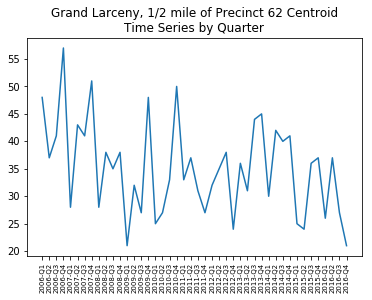

In [23]:
#sum by quarter and plot
df_Q = df[['YEAR','Q','COUNT']].groupby(['YEAR','Q'],as_index=False).sum()
df_Q['Y_Q'] = df_Q.YEAR.astype(str) + '-Q' + df_Q.Q.astype(str)

#plot the quarterly time series 
plt.plot(df_Q.Y_Q, df_Q.COUNT)
plt.xticks(rotation=90,size=7) 
plt.title("\n".join(wrap(titleHM + ' Time Series by Quarter',n_t)))

There doesn't appear to be any consistent seasonality

Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\nLag Plot')

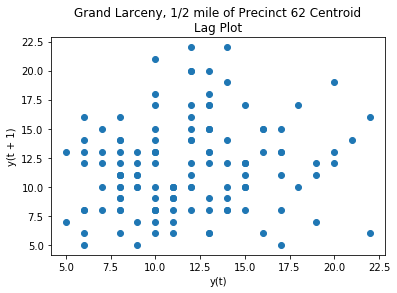

In [24]:
#Lag plot (lag = 1)
lag_plot(df.COUNT)
plt.title("\n".join(wrap(titleHM + ' Lag Plot',n_t)))

Precinct 62 does not appear to have any autocorrelation between the first and second period

Precinct 75 showed some autocorrelation between the first and second time period

Text(0.5,1,'Grand Larceny, 1/2 mile of Precinct 62 Centroid\nAutocorrelation')

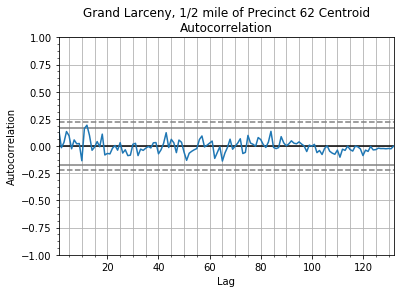

In [25]:
#Autocorrelation plots 
ax = autocorrelation_plot(df.COUNT)
ax.minorticks_on()
ax.xaxis.grid(True, which='both')
ax.set_title("\n".join(wrap(titleHM + ' Autocorrelation',n_t)))

The plot shows no autocorrelation (correlation with previous period(s))  
  
Precinct 75 showed autocorrelation for time periods throughout the first 12 periods

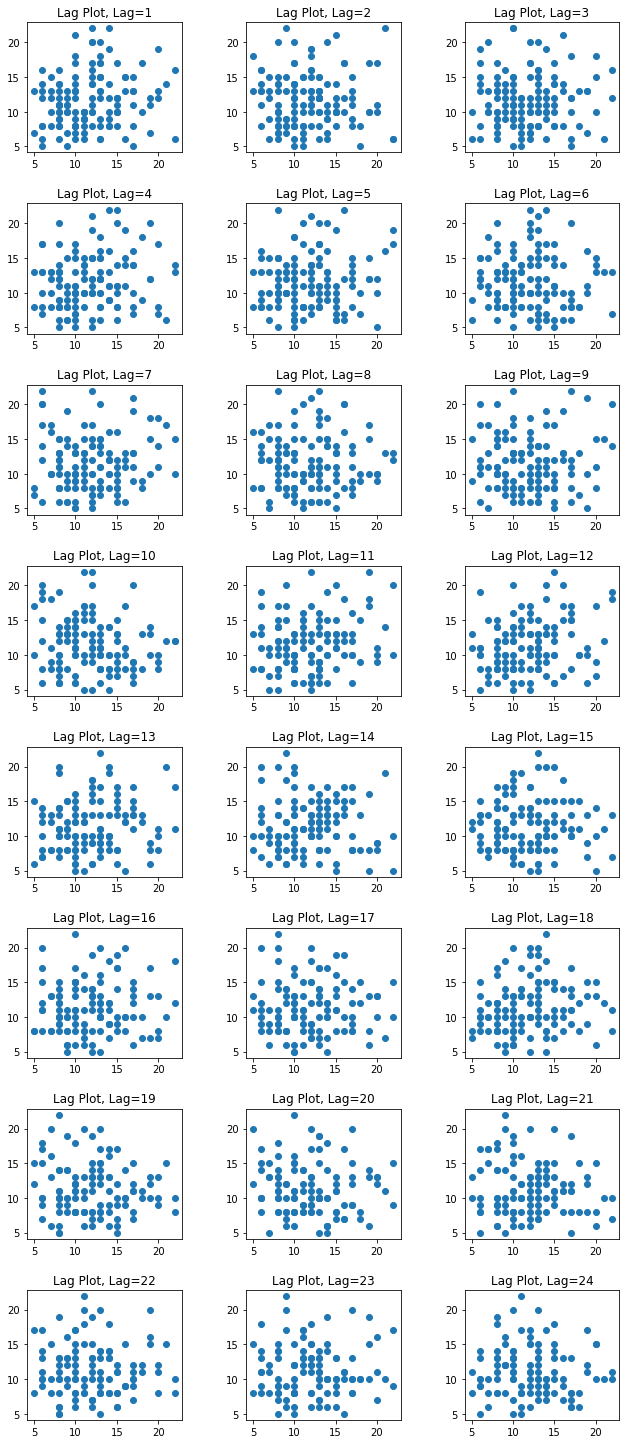

In [26]:
f, axs = plt.subplots(8, 3, figsize=(9,20))
plt.tight_layout(h_pad=3.0,w_pad=3.0)

for i, ax in enumerate(axs.flat):
    s = i + 1
    ax.scatter(df.COUNT.shift(s)[s:],df.COUNT[s:])
    ax.set_title('Lag Plot, Lag=' + str(s))

Scatter plot show no correlation between time periods

In [27]:
#set up a new dataframe
dfM = df.copy()

In [28]:
#Difference by 1
dfM['COUNT_s1'] = dfM['COUNT'].shift(1)
dfM['diff_1'] = df.COUNT - dfM.COUNT_s1
dfM.head(5)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,PCT_YEAR_COUNT,Q,COUNT_s1,diff_1
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,0.103825,1,NaN,NaN
1,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,183,0.065574,1,19.0,-7.0
2,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,183,0.092896,1,12.0,5.0
3,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01,183,0.071038,2,17.0,-4.0
4,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01,183,0.065574,2,13.0,-1.0


Based on the autocorrelation plot the time series is stationary, which would make differencing unnecessary.

In [29]:
#View Time Series of differenced series
#plt.plot(dfM.DATE[1:], dfM.diff_1[1:])
#plt.title("\n".join(wrap(titleHM + ' Time Series (Diff:1)',n_t)))

In [30]:
#Autocorrelation plots 
#autocorrelation_plot(dfM.diff_1[1:])
#plt.title("\n".join(wrap(titleHM + ' Autocorrelation (Diff:1)',n_t)))

# Baseline model/ Transform the data for supervised learning predicting one Month ahead
For Time Series Model the naive model is used as the baseline: the value at the previous time step (t-1) is used to predict the expected outcome at the next time step (t+1)
  
Example:  Predict Jan if Dec is known  
Actual = Jan 2016  
Prediction = Dec 2015    

In [31]:
#Create the target variable: t+1 
#for the Jan observation: y = t+1 = Jan, X = t = Dec
dfM['t+1'] = dfM['COUNT']  #X
dfM['t'] = dfM['COUNT_s1']  #y

In [32]:
dfM.head(3)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,PCT_YEAR_COUNT,Q,COUNT_s1,diff_1,t+1,t
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,0.103825,1,NaN,NaN,19,NaN
1,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,183,0.065574,1,19.0,-7.0,12,19.0
2,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,183,0.092896,1,12.0,5.0,17,12.0


# Split into train, validate and test sets
For time series data the data must be split at a time point, rather than selecting randomly.  
Training set = 2006 - 2014  
Validation set = 2015  
Test set = 2016  

In [33]:
train = dfM[dfM.YEAR <= 2014].dropna()
val = dfM[dfM.YEAR == 2015].dropna()
test = dfM[dfM.YEAR == 2016].dropna()

In [34]:
val.head(1)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,PCT_YEAR_COUNT,Q,COUNT_s1,diff_1,t+1,t
108,2015,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,8,1,2015-01-01,122,0.065574,1,10.0,-2.0,8,10.0


# Evaluate the Baseline Model (RMSE)

In [35]:
#Calculate RMSE on the validation set
RMSE_baseline_val = mean_squared_error(val['t+1'],val.t) ** 0.5

print('%0.2f'%RMSE_baseline_val)

2.12


In [36]:
#Calculate RMSE on the test set
RMSE_baseline_test = mean_squared_error(test['t+1'],test.t) ** 0.5

print('%0.2f'%RMSE_baseline_test)

3.52


In [37]:
#plot model vs. actual
def plot_model_results(train,val,actual_col,model_col,model_name):
    #Plot model vs actual
    plt.plot(train.DATE,train[actual_col])
    plt.plot(val.DATE,val[model_col], '--', color = 'red')
    plt.plot(val.DATE,val[actual_col],color='green')
    plt.title(model_name + ' Model vs Actual')

In [38]:
#plot model with residuals
def plot_model_resid(train,val,actual_col,model_col,model_name):
    #Plot the model and residuals
    fig, ax1 = plt.subplots()
    ax1.plot(train.DATE,train[actual_col])
    ax1.plot(val.DATE,val[model_col], '--', color = 'red')
    ax1.set_ylabel('model')
    ax1.tick_params('y')

    ax2 = ax1.twinx()
    ax2.plot(val.DATE,val[actual_col] - val[model_col], 'ro', color= 'green')
    ax2.set_ylabel('residuals')
    ax2.tick_params('y')

    ax1.set_title(model_name + ' Model and Residuals')

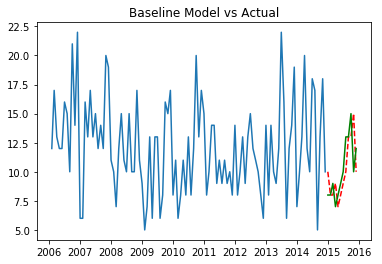

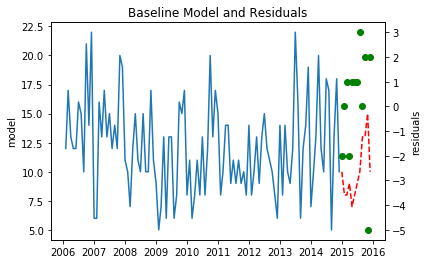

In [39]:
plot_model_results(train,val,'t+1','t','Baseline')
plot_model_resid(train,val,'t+1','t','Baseline')

# Creat a simple regression model
Create a simple regression model with "t+1" as the target (y) and "t" as the feature (X)

**Identify features and target **

In [40]:
#Identify features and target
train_X = train[['t']]
train_y = train[['t+1']]

val_X = val[['t']]
val_y = val[['t+1']]

test_X = test[['t']]
test_y = test[['t+1']]

**Scale the features **

In [41]:
#use the training set to create a standard scaler for validation 
#and test sets, finds the mean and standard deviation of the train set
scaler_M1 = StandardScaler().fit(train_X)

In [42]:
#transform the features for all sets using the scaler created from the 
#train set, this will subtract the mean to center the data and 
#divide by the standard deviation to scale it
train_X_scaled = scaler_M1.transform(train_X)
val_X_scaled = scaler_M1.transform(val_X)
test_X_scaled = scaler_M1.transform(test_X)
len(train_X_scaled),len(val_X_scaled),len(test_X_scaled)

(107, 12, 12)

** Implement Linear Regression **

In [43]:
#create a linear regression
regr_M1 = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

In [44]:
#fit the regression model
regr_M1.fit(train_X_scaled, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

** Evaluate the performance of the model on the validation set **

In [45]:
#predict the target values of the validation set using the model
val['M1'] = regr_M1.predict(val_X_scaled)

In [46]:
#Calculate RMSE on the validation set
RMSE_baseline_val = mean_squared_error(val.M1,val['t+1']) ** 0.5

print('%0.2f'%RMSE_baseline_val)

2.89


In [47]:
train['M1'] = regr_M1.predict(train_X_scaled)
test['M1'] = regr_M1.predict(test_X_scaled)

Performance is worse than the baseline  
For Precinct 75 it was better than the baseline

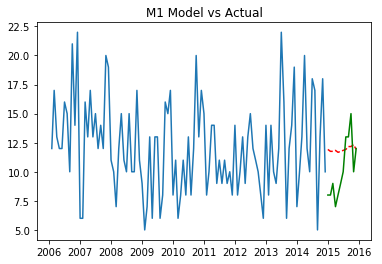

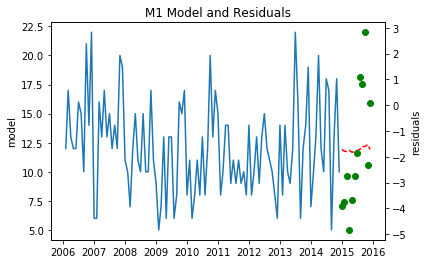

In [48]:
plot_model_results(train,val,'t+1','M1','M1')
plot_model_resid(train,val,'t+1','M1','M1')

In [49]:
#show the actual vs model prediction for training and validation
def plot_model_eval(train,val,actual_col,model_col,model_name):
    #Plot model vs actual
    plt.plot(train.DATE,train[actual_col])
    plt.plot(train.DATE,train[model_col], '--', color = 'red')
    plt.plot(val.DATE,val[model_col], '--', color = 'red')
    plt.plot(val.DATE,val[actual_col],color='green')
    plt.title(model_name + ' Model vs Actual Backtest')

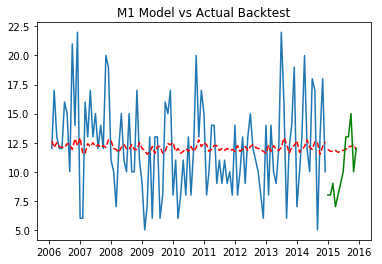

In [50]:
plot_model_eval(train,val,'t+1','M1','M1')

The model seems to be a little too smooth and seems to underfit. 

# Create another model with additional lag variables
Create a regression model with "t+1" as the target (y) and "t" and "t-1" as features

In [51]:
dfM.head()

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,PCT_YEAR_COUNT,Q,COUNT_s1,diff_1,t+1,t
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,0.103825,1,NaN,NaN,19,NaN
1,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,183,0.065574,1,19.0,-7.0,12,19.0
2,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,183,0.092896,1,12.0,5.0,17,12.0
3,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01,183,0.071038,2,17.0,-4.0,13,17.0
4,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01,183,0.065574,2,13.0,-1.0,12,13.0


In [52]:
#add feature t-1 (shift=2)
dfM['t-1'] = dfM['COUNT'].shift(2)

In [53]:
def test_new_feature(feature_list,target,model_num):
    #set up the field list and add the feature_list fields
    field_list = ['YEAR','MONTH','CRIME_CAT',
               'OFFENSE','CAT_OFNS','COUNT','DAY','DATE','COUNT_s1',
               'diff_1'] + [target] + feature_list
    
    #set up the dataframe with these fields
    df_model = dfM[field_list]
  
    #create train,val,test sets to include feature_list
    #and drop rows that now have NA values
    train = df_model[df_model.YEAR <= 2014].dropna()
    val = df_model[df_model.YEAR == 2015].dropna()
    test = df_model[df_model.YEAR == 2016].dropna()
    
    #Identify features and target
    train_X = train[feature_list]
    train_y = train[[target]]

    val_X = val[feature_list]
    val_y = val[[target]]

    test_X = test[feature_list]
    test_y = test[[target]]
       
    #use the training set to create a standard scaler for validation 
    #and test sets, finds the mean and standard deviation of the train set
    scaler = StandardScaler().fit(train_X)
    
    #transform the features for all sets using the scaler created from the 
    #train set, this will subtract the mean to center the data and 
    #divide by the standard deviation to scale it
    train_X_scaled = scaler.transform(train_X)
    val_X_scaled = scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    #print(len(train_X_scaled),len(val_X_scaled),len(test_X_scaled))

    #create a linear regression
    regr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
    
    #fit the regression model
    regr.fit(train_X_scaled, train_y)
    
    m_name = 'M'+str(model_num)
    
    #predict the target values of the validation set using the model
    val[m_name] = regr.predict(val_X_scaled)
    train[m_name] = regr.predict(train_X_scaled)
    test[m_name] = regr.predict(test_X_scaled)
    
    #Calculate RMSE on the validation set
    RMSE_val = mean_squared_error(val[target],val[m_name]) ** 0.5
    print('RMSE: %0.2f'%RMSE_val)
   
    #plot the results
    plot_model_results(train,val,target,m_name,m_name)
    
    plot_model_resid(train,val,target,m_name,m_name)
    plt.figure()
    plot_model_eval(train,val,target,m_name,m_name)
   
    #output the feature scaler, model, val/train/test predictions
    return scaler, regr, val, train, test   


RMSE: 2.99


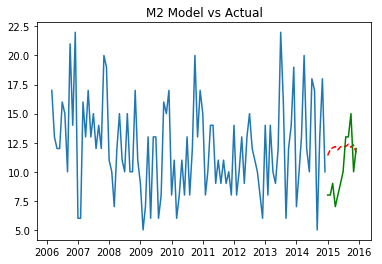

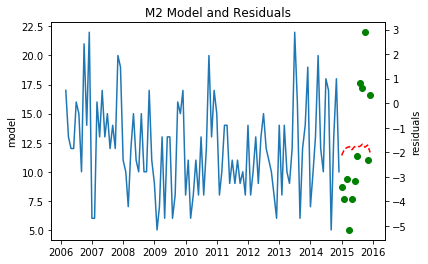

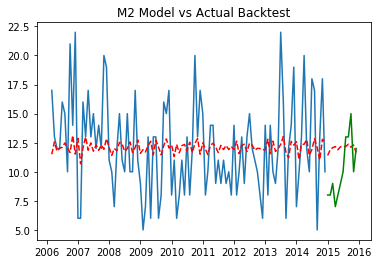

In [54]:
#test model with 't' and 't-1' as features
scaler_M2, regr_M2, val_M2, train_M2, test_M2 = test_new_feature(
    ['t','t-1'],'t+1',2)

RMSE is lower than the baseline and model M1

In [55]:
#add feature t-2, t-3, t-4,t-5 (add 6 months of lag variables)
for i in range(2,6):
    dfM['t-'+str(i)] = dfM['COUNT'].shift(i)

In [56]:
dfM.head()

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,...,Q,COUNT_s1,diff_1,t+1,t,t-1,t-2,t-3,t-4,t-5
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,...,1,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,183,...,1,19.0,-7.0,12,19.0,NaN,NaN,NaN,NaN,NaN
2,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,183,...,1,12.0,5.0,17,12.0,19.0,19.0,NaN,NaN,NaN
3,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01,183,...,2,17.0,-4.0,13,17.0,12.0,12.0,19.0,NaN,NaN
4,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01,183,...,2,13.0,-1.0,12,13.0,17.0,17.0,12.0,19.0,NaN


In [57]:
features3 = list(dfM.iloc[:,-6:])
features3

['t', 't-1', 't-2', 't-3', 't-4', 't-5']

RMSE: 2.96


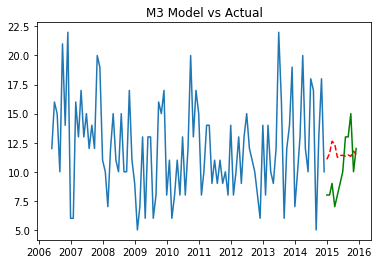

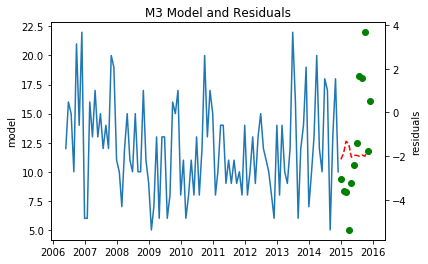

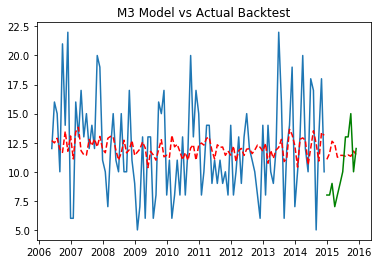

In [58]:
#test model with 't',...'t-23' as features
scaler_M3, regr_M3, val_M3, train_M3, test_M3 = test_new_feature(
    features3,'t+1',3)

The MSE is about the same as M2 and worse than M1 and the baseline

# Compare the trend for Brooklyn and for Precinct 75
see if these are leading in any way

In [59]:
#read data in from pickle file
df_all = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_cleaned_with_XY.pkl')

In [60]:
#rename columns
df_all.rename(columns={'CMPLNT_FR_DATE_YEAR':'YEAR',
 'CMPLNT_FR_DATE_MONTH':'MONTH',
 'LAW_CAT_CD':'CRIME_CAT',
 'OFNS_DESC':'OFFENSE'}, inplace = True)

In [61]:
#create a date (set date for each month as 1st of the month)
df_all['DAY'] = 1 
df_all['DATE'] = pd.to_datetime(df_all[['YEAR','MONTH','DAY']])

In [62]:
#get information for just Brooklyn and Grand Larceny
df_BK_GL = df_all[(df_all.BORO == 'BROOKLYN')& (df_all.OFFENSE == 'GRAND LARCENY')]

In [63]:
#get information for just precinct 75 and Grand Larceny
df_62_GL = df_all[(df_all.PRECINCT == 62)& (df_all.OFFENSE == 'GRAND LARCENY')]

In [64]:
#group complaint data by year, month for Brooklyn Grand Larceny
df_agg = df_BK_GL[['CMPLNT_NUM','DATE']].groupby(['DATE'],
    as_index=False).agg(['count'])

#reformat headers
df_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_agg.columns.values]
df_agg.reset_index(col_level=1,inplace = True)

In [65]:
df_agg_62 = df_62_GL[['CMPLNT_NUM','DATE']].groupby(['DATE'],
    as_index=False).agg(['count'])

#reformat headers
df_agg_62.columns = ['_'.join(tup).rstrip('_') for tup in df_agg_62.columns.values]
df_agg_62.reset_index(col_level=1,inplace = True)

In [66]:
df_agg.head()

,DATE,CMPLNT_NUM_count
0,2006-01-01,947
1,2006-02-01,755
2,2006-03-01,923
3,2006-04-01,910
4,2006-05-01,962


In [67]:
df_agg_62.head()

,DATE,CMPLNT_NUM_count
0,2006-01-01,68
1,2006-02-01,37
2,2006-03-01,47
3,2006-04-01,53
4,2006-05-01,45


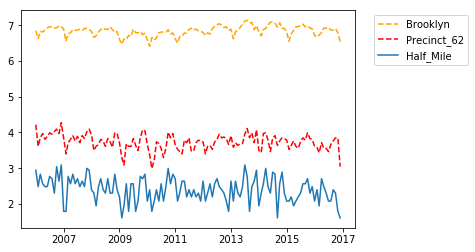

In [68]:
#Half_Mile_GL
#Brooklyn_GL
#Precinct_75_GL
#plot the log of the time series being modeled and for Brooklyn
plt.plot(df_agg.DATE,np.log(df_agg.CMPLNT_NUM_count), '--', color = 'orange')
plt.plot(df_agg_62.DATE,np.log(df_agg_62.CMPLNT_NUM_count), '--', color = 'red')
plt.plot(dfM.DATE,np.log(dfM.COUNT))
L = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
L.get_texts()[2].set_text('Half_Mile')
L.get_texts()[1].set_text('Precinct_62')
L.get_texts()[0].set_text('Brooklyn')

Grand Larceny in Brooklyn has a strong seasonal pattern, precinct 62 appears to have some seasonality at least in earlier year, half mile radius around the precinct 62 centroid doesn't.  This was also true for the 1/2 mile radius around precinct 75.

Text(0.5,1,'Brooklyn Comparison')

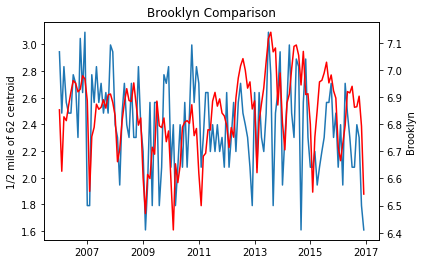

In [69]:
#Plot the timeseries for the point and radius and the timeseries for Brooklyn
#different axes
fig, ax1 = plt.subplots()
ax1.plot(dfM.DATE,np.log(dfM.COUNT))
ax1.set_ylabel('1/2 mile of 62 centroid')
ax1.tick_params('y')

ax2 = ax1.twinx()
ax2.plot(df_agg.DATE,np.log(df_agg.CMPLNT_NUM_count), color = 'red')
ax2.set_ylabel('Brooklyn')
ax2.tick_params('y')

ax1.set_title('Brooklyn Comparison')

In [70]:
df_agg['t_BK'] = df_agg.CMPLNT_NUM_count.shift(1)
df_agg_62['t_Pr_62'] = df_agg_62.CMPLNT_NUM_count.shift(1)

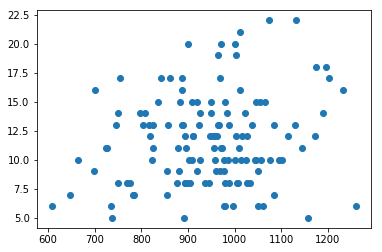

In [71]:
#compare 1/2 mile around the precinct to prior period for Brooklyn 
plt.scatter(df_agg.t_BK.dropna(),dfM.COUNT[1:])

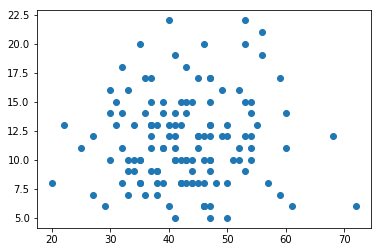

In [72]:
#compare 1/2 mile around the precinct to prior period for the Precinct
plt.scatter(df_agg_62.t_Pr_62.dropna(),dfM.COUNT[1:])

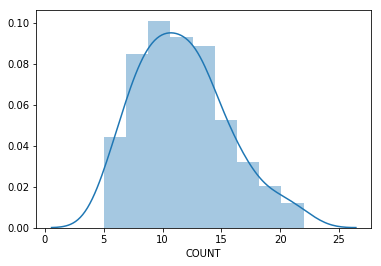

In [73]:
sns.distplot(dfM.COUNT[1:])

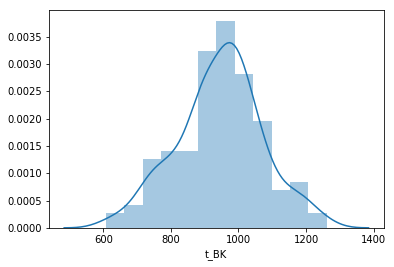

In [74]:
sns.distplot(df_agg.t_BK.dropna())

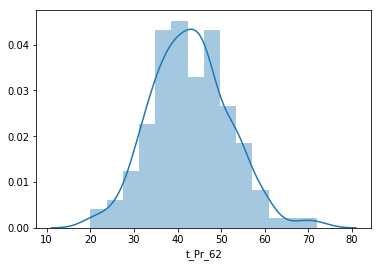

In [75]:
sns.distplot(df_agg_62.t_Pr_62.dropna())

In [76]:
#distributions are are not normally distributed use spearman correlation
df_agg.t_BK.dropna().corr(dfM.COUNT[1:],method='spearman'),df_agg_62.t_Pr_62.dropna().corr(dfM.COUNT[1:],method='spearman')

(0.11076673047518173, 0.034515791099916752)

Correlation is low for Brooklyn, slightly higher for the Precinct

In [77]:
#add prior time period for Brooklyn as a feature
dfM = dfM.merge(df_agg[['DATE','t_BK']], on = 'DATE', how ='left')
dfM = dfM.merge(df_agg_62[['DATE','t_Pr_62']], on = 'DATE', how ='left')

In [78]:
df_agg.head()

,DATE,CMPLNT_NUM_count,t_BK
0,2006-01-01,947,NaN
1,2006-02-01,755,947.0
2,2006-03-01,923,755.0
3,2006-04-01,910,923.0
4,2006-05-01,962,910.0


In [79]:
df_agg_62.head()

,DATE,CMPLNT_NUM_count,t_Pr_62
0,2006-01-01,68,NaN
1,2006-02-01,37,68.0
2,2006-03-01,47,37.0
3,2006-04-01,53,47.0
4,2006-05-01,45,53.0


In [80]:
dfM.head()

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,YEAR_COUNT,...,diff_1,t+1,t,t-1,t-2,t-3,t-4,t-5,t_BK,t_Pr_62
0,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,183,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,183,...,-7.0,12,19.0,NaN,NaN,NaN,NaN,NaN,947.0,68.0
2,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,183,...,5.0,17,12.0,19.0,19.0,NaN,NaN,NaN,755.0,37.0
3,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01,183,...,-4.0,13,17.0,12.0,12.0,19.0,NaN,NaN,923.0,47.0
4,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01,183,...,-1.0,12,13.0,17.0,17.0,12.0,19.0,NaN,910.0,53.0


RMSE: 3.00


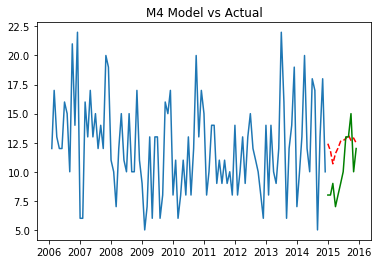

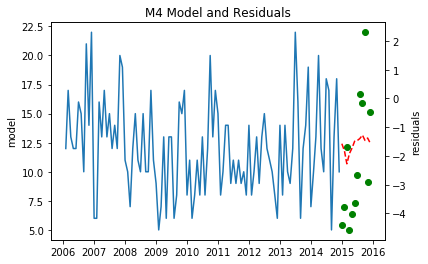

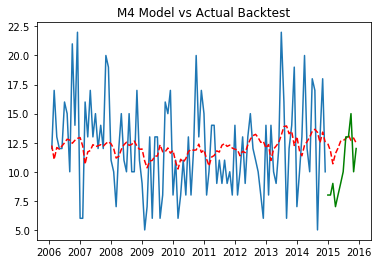

In [81]:
#test model with 't' and 't_BK' as features
scaler_M4, regr_M4, val_M4, train_M4, test_M4 = test_new_feature(
    ['t','t_BK'],'t+1',4)

Adding Brooklyn prior period essentially just brings in the Brooklyn seasonal trend, and the MSE is worse than the baseline and prior models.

RMSE: 2.83


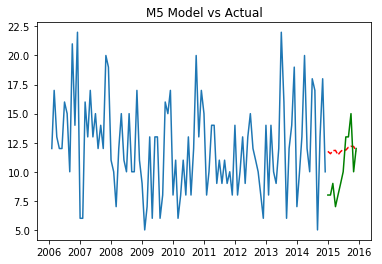

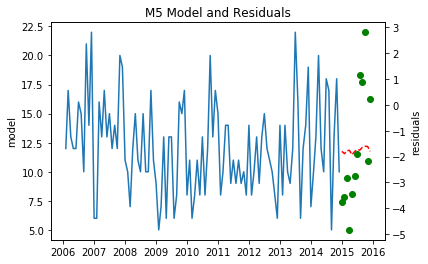

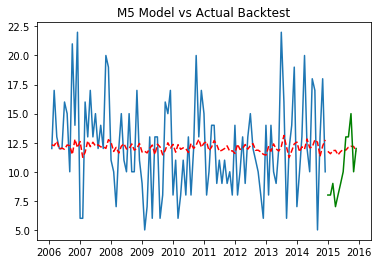

In [82]:
#test model with 't' and 't_Pr_75' as features
scaler_M5, regr_M5, val_M5, train_M5, test_M5 = test_new_feature(
    ['t','t_Pr_62'],'t+1',5)

MSE is also worse than the baseline with the prior period for the precinct

RMSE: 2.95


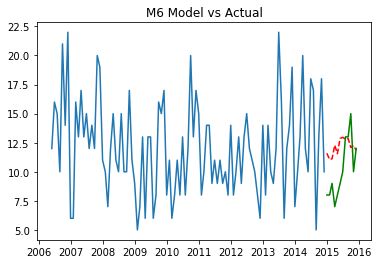

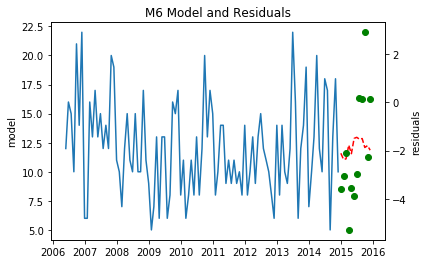

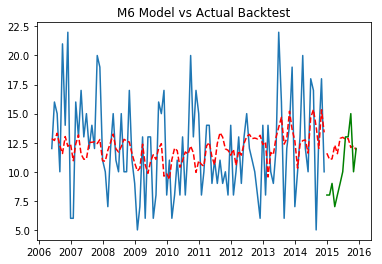

In [83]:
#test model with 't' and 't_Pr_75' as features
scaler_M6, regr_M6, val_M6, train_M6, test_M6 = test_new_feature(
    ['t','t-1', 't-2', 't-3', 't-4', 't-5','t_Pr_62','t_BK'],'t+1',6)

Adding in all features does not improve the MSE over the baseline.

# Compare Models

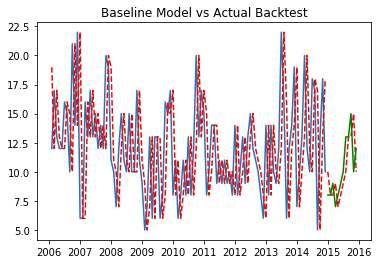

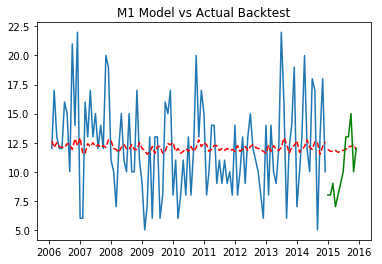

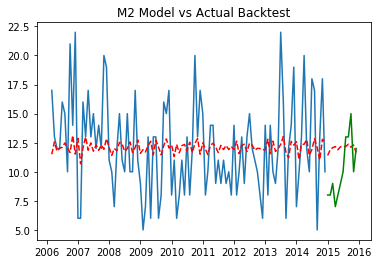

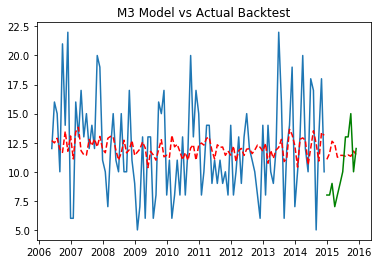

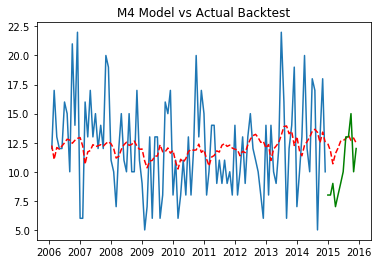

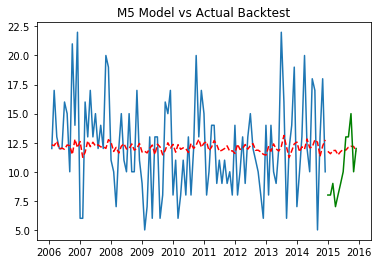

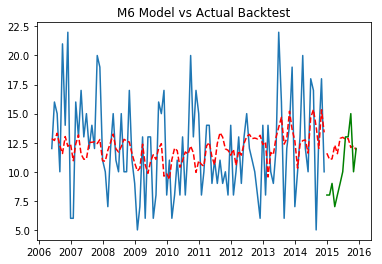

In [87]:
#compare to model 1
plot_model_eval(train,val,'t+1','t','Baseline')
plt.figure()
#M1 - previous period as feature
plot_model_eval(train,val,'t+1','M1','M1')  
plt.figure()
#M2 previous two periods as features
plot_model_eval(train_M2,val_M2,'t+1','M2','M2')
plt.figure()
#M3 previous six periods as features
plot_model_eval(train_M3,val_M3,'t+1','M3','M3')
plt.figure()
#M4 previous period + Brooklyn previous period as features
plot_model_eval(train_M4,val_M4,'t+1','M4','M4')
plt.figure()
#M5 previous period + Precinct 75 previous period as features
plot_model_eval(train_M5,val_M5,'t+1','M5','M5')
plt.figure()
#M6 previous 6 periods + Precinct 75 and Brooklyn previous period as features
plot_model_eval(train_M6,val_M6,'t+1','M6','M6')

In [85]:
#Check the RMSE on the test sets
RMSE_baseline_test = mean_squared_error(test['t+1'],test.t) ** 0.5
print('RMSE Baseline %0.2f'%RMSE_baseline_test)
RMSE_test_M1 = mean_squared_error(test['t+1'],test.M1) ** 0.5
print('RMSE M1: %0.2f'%RMSE_test_M1)
RMSE_test_M2 = mean_squared_error(test['t+1'],test_M2.M2) ** 0.5
print('RMSE M2: %0.2f'%RMSE_test_M2)
RMSE_test_M3 = mean_squared_error(test['t+1'],test_M3.M3) ** 0.5
print('RMSE M3: %0.2f'%RMSE_test_M3)
RMSE_test_M4 = mean_squared_error(test['t+1'],test_M4.M4) ** 0.5
print('RMSE M4: %0.2f'%RMSE_test_M4)
RMSE_test_M5 = mean_squared_error(test['t+1'],test_M5.M5) ** 0.5
print('RMSE M5: %0.2f'%RMSE_test_M5)
RMSE_test_M6 = mean_squared_error(test['t+1'],test_M6.M6) ** 0.5
print('RMSE M6: %0.2f'%RMSE_test_M6)

RMSE Baseline 3.52
RMSE M1: 3.77
RMSE M2: 3.88
RMSE M3: 3.66
RMSE M4: 3.96
RMSE M5: 3.72
RMSE M6: 3.89


Baseline - next equal previous  
M1 - previous period as feature  
M2 - previous two periods as features  
M3 - previous six periods as features  
M4 - previous period + Brooklyn previous period as features  
M5 - previous period + Precinct 62 previous period as features  
M6 - all of the above features
  
None of the models outperform the Baseline in the validation or the test set

Text(0.5,1,'Model Prediction on the test sets')

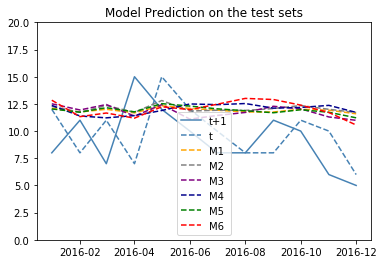

In [88]:
#plot the predictions on the test set
plt.plot(test.DATE,test['t+1'],color='steelblue')
plt.plot(test.DATE,test['t'],'--',color='steelblue')
plt.plot(test.DATE,test.M1,'--',color='orange')
plt.plot(test.DATE,test_M2.M2,'--',color='grey')
plt.plot(test.DATE,test_M3.M3,'--',color='purple')
plt.plot(test.DATE,test_M4.M4,'--',color='darkblue')
plt.plot(test.DATE,test_M5.M5,'--',color='green')
plt.plot(test.DATE,test_M6.M6,'--',color='red')
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,20])
plt.legend()
plt.title('Model Prediction on the test sets')